In [1]:
import torch 
from torchvision.transforms import transforms
import numpy as np
import glob
from skimage import io
from src.datamodules.components.focus_dataset import FocusDataset
from src.datamodules.components.patch_dataset import PatchFocusDataset
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import os
import seaborn as sns

In [2]:
def brenner_gradient(img: np.array) -> int:
        return np.sum((img[2:]-img[:-2])**2)

In [3]:
d = torch.load("/home/maf4031/focus_model/data/datasets/dataset_subsample10_grid_complete.pt")
len(d)

76394

In [6]:
d1 = torch.load("/home/maf4031/focus_model/data/datasets/dataset_subsample100_grid1.pt")
len(d)

560446

In [58]:
labels = np.array(d.array_labels)
len(labels)

563952

In [59]:
label_idx, label_counts = np.unique(labels, return_counts=True)

In [60]:
label_counts[np.where(label_idx == 0)[0]]

array([2817])

In [61]:
print(min(label_idx))
print(max(label_idx))
print(np.mean(label_idx))

-758
502
-78.48387096774194


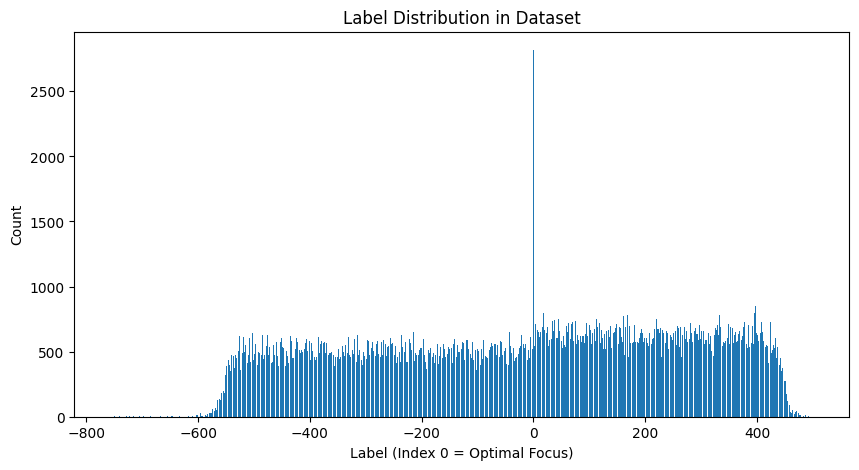

In [62]:
plt.figure(figsize=(10, 5))

plt.bar(label_idx, label_counts)
plt.title("Label Distribution in Dataset")
plt.xlabel("Label (Index 0 = Optimal Focus)")
plt.ylabel("Count")
plt.show()

In [40]:
sample_num = 3
path = f"/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_{sample_num}"
img_paths = glob.glob(f"{path}/distance*")
len(img_paths)

1000

In [41]:
patch_size = (360, 256)
img = io.imread(os.path.join(path, "distance0.jpg"))
h, w, _ = img.shape
x_steps = int(h / patch_size[0])
y_steps = int(w / patch_size[1])
x_coord = np.linspace(int(patch_size[0]/2), h - int(patch_size[0]/2), x_steps)
y_coord = np.linspace(int(patch_size[1]/2), w - int(patch_size[1]/2), y_steps)

patch_coord = [(x, y) for x in x_coord for y in y_coord]

In [42]:
sorted_img_path = sorted(img_paths, key=lambda x: int(x.split("distance")[-1].split(".")[0]))
patch_list = [[] for p in range(len(patch_coord))]
for img_path in sorted_img_path:
    img = io.imread(img_path)
    for idx, (x, y) in enumerate(patch_coord):
        patch = img[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))]
        brenner_value = brenner_gradient(patch)
        patch_list[idx].append(brenner_value)

In [53]:
img_1 = io.imread("/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance-5.jpg")
img_2 = io.imread("/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance-2.jpg")
print(brenner_gradient(img_1) < brenner_gradient(img_2))

x, y = patch_coord[1]
patch_1 = img_1[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))]
patch_2 = img_2[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))]
print(brenner_gradient(patch_1) < brenner_gradient(patch_2))

True
False


In [66]:
patch_idx = 9

brenner_values = sorted(patch_list[patch_idx], reverse=True)
for value in brenner_values:
    max_idx = patch_list[patch_idx].index(value)

max_brenner = max(patch_list[patch_idx])
max_idx = patch_list[patch_idx].index(max_brenner)
optimal_idx = sorted_img_path[max_idx].split("distance")[-1].split(".")[0]

brenner_right, brenner_left = [], []
for value in brenner_values:
    idx = patch_list[patch_idx].index(value)
    path = sorted_img_path[idx]
    if path.split("distance")[-1].split(".")[0] ==  optimal_idx:
        pass
    if path.split("distance")[-1].split(".")[0] < optimal_idx:
        brenner_right.append(value)
    else:
        brenner_left.append(value)

/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance9.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance10.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance12.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance8.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance11.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance7.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance13.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance6.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance14.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance5.jpg
/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3/distance15.jpg
/n/data2/hms/dbmi/kyu/lab/

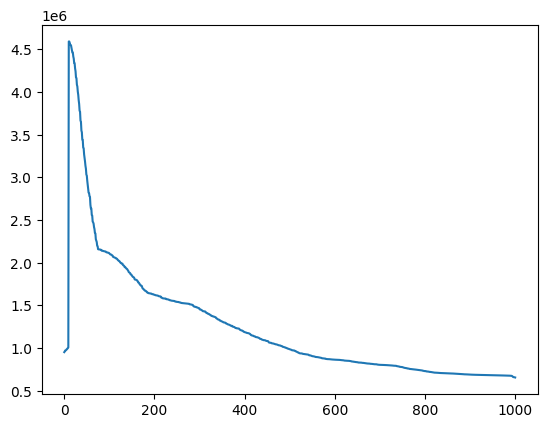

In [67]:
plt.plot([*brenner_left[::-1], max_brenner, *brenner_right])
plt.show()


In [5]:
max_img_path_list = []
for x, y in patch_coord:
    max_brenner = 0
    max_img_path = None
    for img_path in img_paths:
        img = io.imread(img_path)
        curr_brenner = brenner_gradient(img[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))])
        if curr_brenner > max_brenner:
            max_brenner = curr_brenner
            max_img_path = img_path
    max_img_path_list.append(max_img_path.split("distance")[1].split(".")[0])

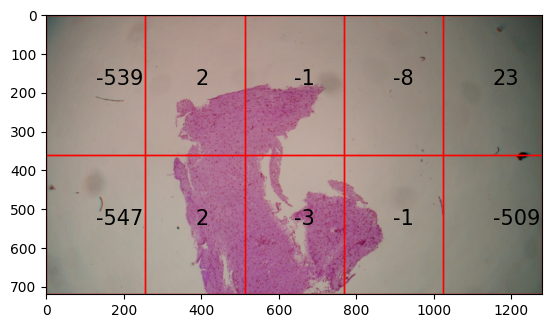

In [6]:
fig, ax = plt.subplots(1)
ax.imshow(img)
for x, y in patch_coord:
    rect = patches.Rectangle((y-int(patch_size[1]/2), x-int(patch_size[0]/2)), patch_size[1], patch_size[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(y, x, max_img_path_list[patch_coord.index((x,y))], color='black', fontsize=15)
plt.show()

In [65]:
patch_coord = [(patch[-2], patch[-1]) for patch in d.array_images if patch[0].split("/")[-2] == f"sample_{sample_num}"]
(len(patch_coord))

5519

In [66]:
max_brenner_list = []
max_img_path_list = []
check_list = []
check_brenner_list = []
for x,y in patch_coord[:1]:
    max_brenner = 0
    max_img_path = None
    check_max_brenner = 0
    check_max_img = None
    for img_path in img_paths:
        img = io.imread(img_path)
        curr_brenner = brenner_gradient(img[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))])
        check_brenner = brenner_gradient(img)
        if curr_brenner > max_brenner:
            max_brenner = curr_brenner
            max_img_path = img_path
        if check_brenner > check_max_brenner:
            check_max_brenner = check_brenner
            check_max_img = img_path
    check_list.append(check_max_img)
    check_brenner_list.append(check_max_brenner)
    max_brenner_list.append(max_brenner)
    max_img_path_list.append(max_img_path)

In [67]:
check_list

['/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_30/distance0.jpg']

In [13]:
max_img_path_list

['/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance5.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance0.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance-2.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance4.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance9.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance6.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance-6.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance-9.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance5.jpg',
 '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_12/distance0.jpg']

In [34]:
i = io.imread("/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_13/distance300.jpg")
i.shape

(720, 1280, 3)

In [ ]:
plt.imshow(i)
plt.show()

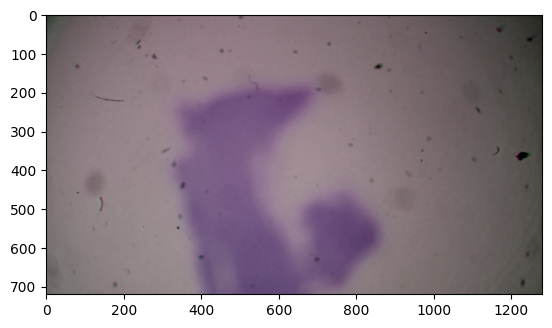

In [51]:
transform_color = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)
transformed_img = transform_color(torch.from_numpy(i).permute(2,0,1))
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

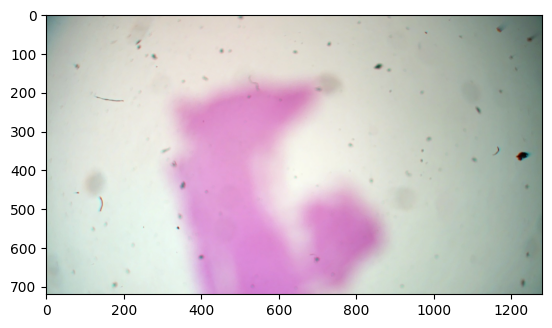

In [38]:
transform_auto = transforms.RandomAutocontrast(p=1.)
transformed_img = transform_auto(torch.from_numpy(i).permute(2,0,1))
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

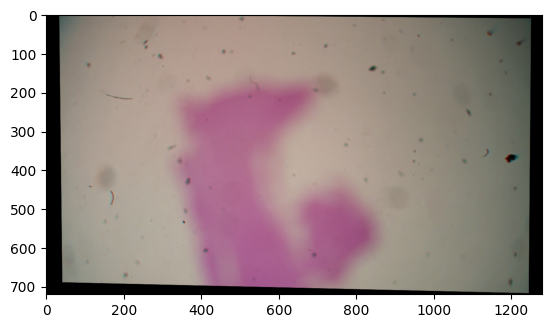

In [41]:
transform_persp = transforms.RandomPerspective(distortion_scale=0.1, p=0.5)
transformed_img = transform_persp(torch.from_numpy(i).permute(2,0,1))
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

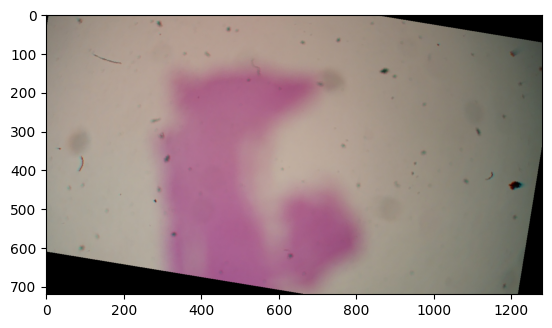

In [43]:
transform_affine = transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1))
transformed_img = transform_affine(torch.from_numpy(i).permute(2,0,1))
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

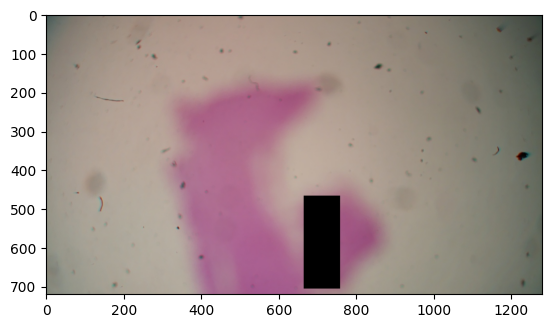

In [48]:
transform_erase = transforms.RandomErasing(p=1.,scale=(0.02, 0.1))
transformed_img = transform_erase(torch.from_numpy(i).permute(2,0,1))
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

In [3]:
def check_correct(path: str):
    max_brenner = 0
    for img in os.listdir(path):
        if img.startswith("distance"):
            i = io.imread(os.path.join(path, img))
            brenner = brenner_gradient(i)
            if brenner > max_brenner:
                max_brenner = brenner
                max_img = img
    print(max_img)

In [4]:
path = "/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_22"

In [9]:
for i in range(15, 20):
    path = f"/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_1_2/sample_{i}"
    check_correct(path)

distance0.jpg
distance1.jpg
distance1.jpg
distance0.jpg
distance1.jpg


In [84]:
405*201

81405